In [1]:
import numpy as np
from scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from statsmodels.formula.api import ols
import optuna
# import optuna.integration.lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import StratifiedKFold,train_test_split, GridSearchCV
# import lightgbm as lgbm
import seaborn as sns
import itertools # 効率的なループ実行のためのイテレータ生成関数のインポート
# sns.set() # デフォルトスタイルにseabornを適用
from scipy.stats import spearmanr
import japanize_matplotlib
from __future__ import division
import numpy as np
from scipy.linalg import kron
from scipy.optimize import fmin_bfgs
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.model_selection import KFold

#import NodeJS
from merf.merf import MERF

# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

In [2]:
merged = pd.read_excel("/Users/ShuntaroMiwa/00_python/(edit)compe2021/20220113/output2022_01_13.xlsx").fillna(0)
                      #index_col=0,  date_parser=my_parser)
# merged = merged.set_index(["地域コード","地域"], drop=True,append=True)#,  date_parser=my_parser)
merged.head()

sex_code sex  age_code     age  year  area_code   地域   転入数    転出数  転入超過数  \
0         1   男        20  20～24歳  2010       1000  北海道  6006  11756  -5750   
1         1   男        20  20～24歳  2010       2000  青森県  2499   6582  -4083   
2         1   男        20  20～24歳  2010       3000  岩手県  2349   6174  -3825   
3         1   男        20  20～24歳  2010       4000  宮城県  6950   9119  -2169   
4         1   男        20  20～24歳  2010       5000  秋田県  1658   4934  -3276   

   ...  愛媛県  高知県  福岡県  佐賀県  長崎県  熊本県  大分県  宮崎県  鹿児島県  沖縄県  
0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
1  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
2  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
3  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
4  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  

[5 rows x 204 columns]

In [3]:
merged.shape

(752, 204)

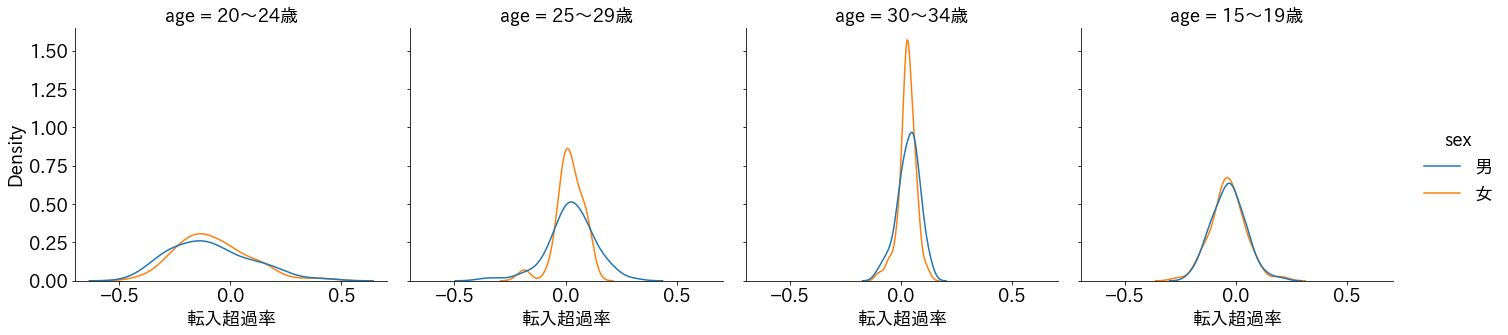

In [5]:
plt.rcParams["font.size"] = 18
sns.displot(data = merged, x = '転入超過率', col="age", hue = 'sex',kind="kde")

In [57]:
merged_g = merged.iloc[:,0:9].groupby(['sex_code', 'area_code','year']).sum()
merged_g['転入超過数'] = merged_g['転入数'] - merged_g['転出数']
merged_g.reset_index()

sex_code  area_code  year  age_code    転入数    転出数  転入超過数
0           1       1000  2010        90  23143  38892 -15749
1           1       1000  2015        90  33611  38766  -5155
2           1       2000  2010        90   9426  16830  -7404
3           1       2000  2015        90  12744  19203  -6459
4           1       3000  2010        90   9572  14872  -5300
..        ...        ...   ...       ...    ...    ...    ...
183         2      45000  2015        90  10625  14818  -4193
184         2      46000  2010        90   9464  13173  -3709
185         2      46000  2015        90  15279  19706  -4427
186         2      47000  2010        90   7879   7585    294
187         2      47000  2015        90  11529  12808  -1279

[188 rows x 7 columns]

In [56]:
merged_g

age_code    転入数    転出数
sex_code area_code year                        
1        1000      2010        90  23143  38892
                   2015        90  33611  38766
         2000      2010        90   9426  16830
                   2015        90  12744  19203
         3000      2010        90   9572  14872
...                           ...    ...    ...
2        45000     2015        90  10625  14818
         46000     2010        90   9464  13173
                   2015        90  15279  19706
         47000     2010        90   7879   7585
                   2015        90  11529  12808

[188 rows x 3 columns]

In [58]:
mm_g = pd.merge(merged_g, merged, left_on=('sex_code','area_code','year' ), right_on=('sex_code','area_code','year' ), how='left')

In [67]:
mm_gg = mm_g[mm_g['age_code_y']==15]

In [68]:
mm_gg.head()

sex_code  area_code  year  age_code_x  転入数_x  転出数_x  転入超過数_x sex  \
3          1       1000  2010          90  23143  38892   -15749   男   
7          1       1000  2015          90  33611  38766    -5155   男   
11         1       2000  2010          90   9426  16830    -7404   男   
15         1       2000  2015          90  12744  19203    -6459   男   
19         1       3000  2010          90   9572  14872    -5300   男   

    age_code_y     age  ...  愛媛県  高知県  福岡県  佐賀県  長崎県  熊本県  大分県  宮崎県  鹿児島県  沖縄県  
3           15  15～19歳  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
7           15  15～19歳  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
11          15  15～19歳  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
15          15  15～19歳  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
19          15  15～19歳  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  

[5 rows x 208 columns]

In [69]:
mm_gg = mm_gg.drop(['age_code_x','age_code_y', 'age','転入超過数_y','転入数_y','転出数_y','転入超過率'], axis = 1)
mm_gg

sex_code  area_code  year  転入数_x  転出数_x  転入超過数_x sex    地域      総人口  \
3           1       1000  2010  23143  38892   -15749   男   北海道  5506419   
7           1       1000  2015  33611  38766    -5155   男   北海道  5381733   
11          1       2000  2010   9426  16830    -7404   男   青森県  1373339   
15          1       2000  2015  12744  19203    -6459   男   青森県  1308265   
19          1       3000  2010   9572  14872    -5300   男   岩手県  1330147   
..        ...        ...   ...    ...    ...      ...  ..   ...      ...   
735         2      45000  2015  10625  14818    -4193   女   宮崎県  1104069   
739         2      46000  2010   9464  13173    -3709   女  鹿児島県  1706242   
743         2      46000  2015  15279  19706    -4427   女  鹿児島県  1648177   
747         2      47000  2010   7879   7585      294   女   沖縄県  1392818   
751         2      47000  2015  11529  12808    -1279   女   沖縄県  1433566   

     30_34歳女性人口  ...  愛媛県  高知県  福岡県  佐賀県  長崎県  熊本県  大分県  宮崎県  鹿児島県  沖縄県  
3     31.074642  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
7     27.091273  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
11    28.088476  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
15    24.717469  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
19    27.720244  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
..          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  
735   26.850677  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
739   29.106657  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
743   27.475204  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
747   34.373479  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
751   31.907146  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  

[188 rows x 201 columns]

In [71]:
mm_gg['転入超過率'] = mm_gg['転入超過数_x']/mm_gg['総人口']*100  
mm_gg

sex_code  area_code  year  転入数_x  転出数_x  転入超過数_x sex    地域      総人口  \
3           1       1000  2010  23143  38892   -15749   男   北海道  5506419   
7           1       1000  2015  33611  38766    -5155   男   北海道  5381733   
11          1       2000  2010   9426  16830    -7404   男   青森県  1373339   
15          1       2000  2015  12744  19203    -6459   男   青森県  1308265   
19          1       3000  2010   9572  14872    -5300   男   岩手県  1330147   
..        ...        ...   ...    ...    ...      ...  ..   ...      ...   
735         2      45000  2015  10625  14818    -4193   女   宮崎県  1104069   
739         2      46000  2010   9464  13173    -3709   女  鹿児島県  1706242   
743         2      46000  2015  15279  19706    -4427   女  鹿児島県  1648177   
747         2      47000  2010   7879   7585      294   女   沖縄県  1392818   
751         2      47000  2015  11529  12808    -1279   女   沖縄県  1433566   

     30_34歳女性人口  ...  高知県  福岡県  佐賀県  長崎県  熊本県  大分県  宮崎県  鹿児島県  沖縄県     転入超過率  
3     31.074642  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0 -0.286012  
7     27.091273  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0 -0.095787  
11    28.088476  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0 -0.539124  
15    24.717469  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0 -0.493707  
19    27.720244  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0 -0.398452  
..          ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...       ...  
735   26.850677  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0 -0.379777  
739   29.106657  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0 -0.217378  
743   27.475204  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0 -0.268600  
747   34.373479  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.021108  
751   31.907146  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0 -0.089218  

[188 rows x 202 columns]

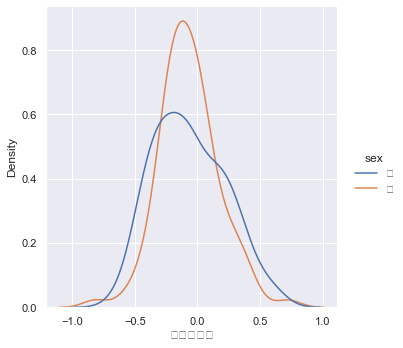

In [74]:
sns.displot(data = mm_gg, x = '転入超過率', hue = 'sex',kind="kde")

<AxesSubplot:xlabel='sex', ylabel='転入超過率'>

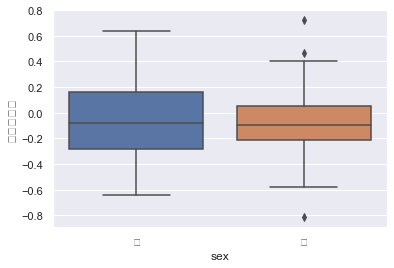

In [94]:
sns.boxplot(data = mm_gg, y = '転入超過率', x = 'sex')

In [78]:
mm_gg.columns

Index(['sex_code', 'area_code', 'year', '転入数_x', '転出数_x', '転入超過数_x', 'sex',
       '地域', '総人口', '30_34歳女性人口',
       ...
       '高知県', '福岡県', '佐賀県', '長崎県', '熊本県', '大分県', '宮崎県', '鹿児島県', '沖縄県',
       '転入超過率'],
      dtype='object', length=202)

In [265]:
mm_gg.to_csv('mm_gg.csv', encoding='utf_8_sig') 

## 加工

In [81]:
# 説明変数のリスト
exog = mm_gg.iloc[:,10:154].columns.tolist()
exog

['共働き世帯数',
 '完全失業者数',
 '非労働力人口女',
 '一般世帯数_総数',
 '一般世帯数_父子母子世帯',
 '一般世帯数_３世代世帯',
 '婚姻件数',
 '離婚件数',
 '平均婚姻年齢_初婚の妻',
 '現に保護を受けた生活保護被保護実世帯数【世帯】',
 '要保護_準要保護児童生徒数合計',
 '大学・短大数',
 '専修学校数',
 '大学・短大学生数',
 '専修学校生徒数',
 '女性の高等学校卒業者のうち進学者数',
 '女性の高等学校卒業者のうち就職者数',
 '幼稚園定員数',
 '保育所等定員数',
 '一般診療所数',
 '教育費_都道府県財政',
 '女性の地元就職進学者数',
 '女性の流入大学・短大進学者総数',
 '女性の流出大学・短大進学者総数',
 '月間有効求人数_一般',
 '県内総生産額_農林業',
 '県内総生産額_水産業',
 '県内総生産額_鉱業',
 '県内総生産額_製造業',
 '県内総生産額_建設業',
 '県内総生産額_電気_ガス_水道_廃棄物処理業',
 '県内総生産額_卸売_小売業',
 '県内総生産額_金融_保険業',
 '県内総生産額_不動産業',
 '県内総生産額_運輸_郵便業',
 '県内総生産額_情報通信業',
 '県内総生産額_公務',
 '民営事業所数',
 '民営事業所数従業者３００人以上',
 '従業者数_民営事業所',
 '従業者数_民営事業所300人以上',
 '可住地面積',
 '映画館、劇場、音楽会場等の数',
 'ガソリン販売量',
 '就業者数女',
 '就業者数女_家族従事者',
 '就業者数女_Ａ農業_林業',
 '就業者数女_Ｂ漁業',
 '就業者数女_Ｄ建設業',
 '就業者数女_Ｅ製造業',
 '就業者数女_Ｆ電気_ガス_熱供給_水道業',
 '就業者数女_Ｇ情報通信業',
 '就業者数女_Ｈ運輸業_郵便業',
 '就業者数女_Ｉ卸売業_小売業',
 '就業者数女_Ｊ金融業_保険業',
 '就業者数女_Ｋ不動産業_物品賃貸業',
 '就業者数女_Ｌ学術研究_専門_技術サービス業',
 '就業者数女_Ｍ宿泊業_飲食サービス業',
 '就業者数女_Ｎ生活関連サービス業_娯楽業',
 '就業者数女_О教育_学習支援業',
 '就業者数女_Ｐ医療_福祉'

In [82]:
# 全ての変数のリスト
var = ['転入超過率'] + exog
print(var)

['転入超過率', '共働き世帯数', '完全失業者数', '非労働力人口女', '一般世帯数_総数', '一般世帯数_父子母子世帯', '一般世帯数_３世代世帯', '婚姻件数', '離婚件数', '平均婚姻年齢_初婚の妻', '現に保護を受けた生活保護被保護実世帯数【世帯】', '要保護_準要保護児童生徒数合計', '大学・短大数', '専修学校数', '大学・短大学生数', '専修学校生徒数', '女性の高等学校卒業者のうち進学者数', '女性の高等学校卒業者のうち就職者数', '幼稚園定員数', '保育所等定員数', '一般診療所数', '教育費_都道府県財政', '女性の地元就職進学者数', '女性の流入大学・短大進学者総数', '女性の流出大学・短大進学者総数', '月間有効求人数_一般', '県内総生産額_農林業', '県内総生産額_水産業', '県内総生産額_鉱業', '県内総生産額_製造業', '県内総生産額_建設業', '県内総生産額_電気_ガス_水道_廃棄物処理業', '県内総生産額_卸売_小売業', '県内総生産額_金融_保険業', '県内総生産額_不動産業', '県内総生産額_運輸_郵便業', '県内総生産額_情報通信業', '県内総生産額_公務', '民営事業所数', '民営事業所数従業者３００人以上', '従業者数_民営事業所', '従業者数_民営事業所300人以上', '可住地面積', '映画館、劇場、音楽会場等の数', 'ガソリン販売量', '就業者数女', '就業者数女_家族従事者', '就業者数女_Ａ農業_林業', '就業者数女_Ｂ漁業', '就業者数女_Ｄ建設業', '就業者数女_Ｅ製造業', '就業者数女_Ｆ電気_ガス_熱供給_水道業', '就業者数女_Ｇ情報通信業', '就業者数女_Ｈ運輸業_郵便業', '就業者数女_Ｉ卸売業_小売業', '就業者数女_Ｊ金融業_保険業', '就業者数女_Ｋ不動産業_物品賃貸業', '就業者数女_Ｌ学術研究_専門_技術サービス業', '就業者数女_Ｍ宿泊業_飲食サービス業', '就業者数女_Ｎ生活関連サービス業_娯楽業', '就業者数女_О教育_学習支援業', '就業者数女_Ｐ医療_福祉', '就業者数女_Ｑ複合サービス事業', '就業者数女_Ｒサービス業他に分類されないもの', '就業者

In [83]:
# 使う変数だけで構成されるDataFrame
df = mm_gg.loc[:,['sex_code', 'year']+exog]# 目的変数及び'area_code'は除外

# varの平均からの乖離を計算
df_g = df.groupby(['sex_code', 'year'])# 'area_code'は除外
df_mean = df_g[exog].transform('mean')
df_md = df.loc[:,exog]-df_mean

In [84]:
df_mean.tail()

共働き世帯数     完全失業者数     非労働力人口女    一般世帯数_総数  一般世帯数_父子母子世帯  一般世帯数_３世代世帯  \
735  274.006882  20.736473  217.864836  401.881754     26.708365    78.178169   
739  274.044403  32.479243  220.054905  386.260698     28.227423    96.925989   
743  274.006882  20.736473  217.864836  401.881754     26.708365    78.178169   
747  274.044403  32.479243  220.054905  386.260698     28.227423    96.925989   
751  274.006882  20.736473  217.864836  401.881754     26.708365    78.178169   

         婚姻件数      離婚件数  平均婚姻年齢_初婚の妻  現に保護を受けた生活保護被保護実世帯数【世帯】  ...  \
735  4.649005  1.729902    29.151064                26.589769  ...   
739  5.055501  1.886901    28.529787                23.696525  ...   
743  4.649005  1.729902    29.151064                26.589769  ...   
747  5.055501  1.886901    28.529787                23.696525  ...   
751  4.649005  1.729902    29.151064                26.589769  ...   

     特化係数_従業者数女_Ｃ事務従事者  特化係数_従業者数女_Ｄ販売従事者  特化係数_従業者数女_Ｅサービス職業従事者  \
735           0.940391           0.972769               1.035585   
739           0.595420           0.557274               0.616298   
743           0.940391           0.972769               1.035585   
747           0.595420           0.557274               0.616298   
751           0.940391           0.972769               1.035585   

     特化係数_従業者数女_Ｆ保安職業従事者  特化係数_従業者数女_Ｇ農林漁業従事者  特化係数_従業者数女_Ｈ生産工程従事者  \
735             0.939329             1.449144             1.118532   
739             0.473244             0.764757             0.623670   
743             0.939329             1.449144             1.118532   
747             0.473244             0.764757             0.623670   
751             0.939329             1.449144             1.118532   

     特化係数_従業者数女_Ｉ輸送_機械運転従事者  特化係数_従業者数女_Ｊ建設_採掘従事者  特化係数_従業者数女_Ｋ運搬_清掃_包装等従事者  \
735                0.965966              1.086605                  0.987552   
739                0.482136              0.563181                  0.539816   
743                0.965966              1.086605                  0.987552   
747                0.482136              0.563181                  0.539816   
751                0.965966              1.086605                  0.987552   

     特化係数_従業者数女_Ｌ分類不能の職業  
735             0.734427  
739             0.419303  
743             0.734427  
747             0.419303  
751             0.734427  

[5 rows x 144 columns]

In [85]:
df_md.head()

共働き世帯数     完全失業者数    非労働力人口女   一般世帯数_総数  一般世帯数_父子母子世帯  一般世帯数_３世代世帯  \
3  -61.633230   2.454531  20.212681  52.918558      2.504432   -57.477698   
7  -62.598166   1.179330  17.797171  51.170451      0.822533   -46.028712   
11  -0.941888  13.455519  15.854801 -13.863934     11.287503    34.367431   
15   1.774133   6.102126  15.598568 -12.632634      8.487152    31.567511   
19  21.632264   3.628796  10.432402 -23.259466      3.639946    53.847033   

        婚姻件数      離婚件数  平均婚姻年齢_初婚の妻  現に保護を受けた生活保護被保護実世帯数【世帯】  ...  \
3   0.100118  0.400611     0.170213                21.858523  ...   
7   0.082742  0.353256     0.148936                24.013010  ...   
11 -0.741927  0.063819    -0.429787                18.358353  ...   
15 -0.496941  0.002927    -0.151064                20.266238  ...   
19 -0.752218 -0.137471    -0.329787                -2.617297  ...   

    特化係数_従業者数女_Ｃ事務従事者  特化係数_従業者数女_Ｄ販売従事者  特化係数_従業者数女_Ｅサービス職業従事者  \
3            0.262885           0.444280               0.477581   
7           -0.085944           0.008157               0.051576   
11          -0.405384          -0.429979              -0.426088   
15          -0.174223          -0.022167               0.010706   
19           0.199060           0.373346               0.401921   

    特化係数_従業者数女_Ｆ保安職業従事者  特化係数_従業者数女_Ｇ農林漁業従事者  特化係数_従業者数女_Ｈ生産工程従事者  \
3              1.087461             1.020060             0.185381   
7              0.467731             0.457742            -0.323002   
11            -0.469064            -0.648993            -0.517277   
15             0.632052             2.034747            -0.014736   
19             0.079314             2.245512             0.775280   

    特化係数_従業者数女_Ｉ輸送_機械運転従事者  特化係数_従業者数女_Ｊ建設_採掘従事者  特化係数_従業者数女_Ｋ運搬_清掃_包装等従事者  \
3                 0.658686              0.597818                  0.735931   
7                 0.068415             -0.133498                  0.257886   
11               -0.479767             -0.560813                 -0.456974   
15               -0.030988              0.166362                  0.129279   
19                0.352037              0.446960                  0.483072   

    特化係数_従業者数女_Ｌ分類不能の職業  
3              0.500495  
7              0.325882  
11            -0.394743  
15            -0.139559  
19            -0.181916  

[5 rows x 144 columns]

In [ ]:
df_corr = df_md.corr()# 変数:df2_corrに相関係数の算出値を代入
df_corr.to_csv('cor_time.csv', encoding='utf_8_sig') 

In [185]:
X = pd.concat([mm_gg.loc[:,['sex_code','area_code','year']], df_md.iloc[:,0:]], axis=1)
y = mm_gg.loc[:,['sex_code','area_code','year','転入超過率']]
y.tail()

sex_code  area_code  year     転入超過率
735         2      45000  2015 -0.379777
739         2      46000  2010 -0.217378
743         2      46000  2015 -0.268600
747         2      47000  2010  0.021108
751         2      47000  2015 -0.089218

In [186]:
X['cluster'] = X['year'].astype(str) + X['sex_code'].astype(str)
y['cluster'] = y['year'].astype(str) + y['sex_code'].astype(str)

In [187]:
X.head()

sex_code  area_code  year     共働き世帯数     完全失業者数    非労働力人口女   一般世帯数_総数  \
3          1       1000  2010 -61.633230   2.454531  20.212681  52.918558   
7          1       1000  2015 -62.598166   1.179330  17.797171  51.170451   
11         1       2000  2010  -0.941888  13.455519  15.854801 -13.863934   
15         1       2000  2015   1.774133   6.102126  15.598568 -12.632634   
19         1       3000  2010  21.632264   3.628796  10.432402 -23.259466   

    一般世帯数_父子母子世帯  一般世帯数_３世代世帯      婚姻件数  ...  特化係数_従業者数女_Ｄ販売従事者  \
3       2.504432   -57.477698  0.100118  ...           0.444280   
7       0.822533   -46.028712  0.082742  ...           0.008157   
11     11.287503    34.367431 -0.741927  ...          -0.429979   
15      8.487152    31.567511 -0.496941  ...          -0.022167   
19      3.639946    53.847033 -0.752218  ...           0.373346   

    特化係数_従業者数女_Ｅサービス職業従事者  特化係数_従業者数女_Ｆ保安職業従事者  特化係数_従業者数女_Ｇ農林漁業従事者  \
3                0.477581             1.087461             1.020060   
7                0.051576             0.467731             0.457742   
11              -0.426088            -0.469064            -0.648993   
15               0.010706             0.632052             2.034747   
19               0.401921             0.079314             2.245512   

    特化係数_従業者数女_Ｈ生産工程従事者  特化係数_従業者数女_Ｉ輸送_機械運転従事者  特化係数_従業者数女_Ｊ建設_採掘従事者  \
3              0.185381                0.658686              0.597818   
7             -0.323002                0.068415             -0.133498   
11            -0.517277               -0.479767             -0.560813   
15            -0.014736               -0.030988              0.166362   
19             0.775280                0.352037              0.446960   

    特化係数_従業者数女_Ｋ運搬_清掃_包装等従事者  特化係数_従業者数女_Ｌ分類不能の職業  cluster  
3                   0.735931             0.500495    20101  
7                   0.257886             0.325882    20151  
11                 -0.456974            -0.394743    20101  
15                  0.129279            -0.139559    20151  
19                  0.483072            -0.181916    20101  

[5 rows x 148 columns]

In [188]:
X_1_10 = X.query('cluster == "20101"')
X_1_15 = X.query('cluster == "20151"')
X_2_10 = X.query('cluster == "20102"')
X_2_15 = X.query('cluster == "20152"')
y_1_10 = y.query('cluster == "20101"')
y_1_15 = y.query('cluster == "20151"')
y_2_10 = y.query('cluster == "20102"')
y_2_15 = y.query('cluster == "20152"')

In [114]:
X_1_10 = X.query('sex_code == 1 & year == 2010')
X_1_15 = X.query('sex_code == 1 & year == 2015')
X_2_10 = X.query('sex_code == 2 & year == 2010')
X_2_15 = X.query('sex_code == 2 & year == 2015')
y_1_10 = y.query('sex_code == 1 & year == 2010')
y_1_15 = y.query('sex_code == 1 & year == 2015')
y_2_10 = y.query('sex_code == 2 & year == 2010')
y_2_15 = y.query('sex_code == 2 & year == 2015')

In [250]:
X_1_10_trainval, X_1_10_test, y_1_10_trainval, y_1_10_test = train_test_split(X_1_10, y_1_10, test_size=0.20,  shuffle=True)#ランダム固定、0の数字には意味はない
X_1_10_train, X_1_10_val, y_1_10_train, y_1_10_val = train_test_split(X_1_10_trainval, y_1_10_trainval, test_size=0.20,  shuffle=True)

In [251]:
X_1_15_trainval, X_1_15_test, y_1_15_trainval, y_1_15_test = train_test_split(X_1_15, y_1_15, test_size=0.20,  shuffle=True)#ランダム固定、0の数字には意味はない
X_1_15_train, X_1_15_val, y_1_15_train, y_1_15_val = train_test_split(X_1_15_trainval, y_1_15_trainval, test_size=0.20,  shuffle=True)

In [252]:
X_2_10_trainval, X_2_10_test, y_2_10_trainval, y_2_10_test = train_test_split(X_2_10, y_2_10, test_size=0.20,  shuffle=True)#ランダム固定、0の数字には意味はない
X_2_10_train, X_2_10_val, y_2_10_train, y_2_10_val = train_test_split(X_2_10_trainval, y_2_10_trainval, test_size=0.20,  shuffle=True)

In [253]:
X_2_15_trainval, X_2_15_test, y_2_15_trainval, y_2_15_test = train_test_split(X_2_15, y_2_15, test_size=0.20,  shuffle=True)#ランダム固定、0の数字には意味はない
X_2_15_train, X_2_15_val, y_2_15_train, y_2_15_val = train_test_split(X_2_15_trainval, y_2_15_trainval, test_size=0.20,  shuffle=True)

In [254]:
X_train_ = pd.concat([X_1_10_train, X_1_15_train, X_2_10_train, X_2_15_train], axis=0)
X_test_ = pd.concat([X_1_10_test, X_1_15_test, X_2_10_test, X_2_15_test], axis=0)
X_val_ = pd.concat([X_1_10_val, X_1_15_val, X_2_10_val, X_2_15_val], axis=0)

In [255]:
y_train_ = pd.concat([y_1_10_train, y_1_15_train, y_2_10_train, y_2_15_train], axis=0)
y_test_ = pd.concat([y_1_10_test, y_1_15_test, y_2_10_test, y_2_15_test], axis=0)
y_val_ = pd.concat([y_1_10_val, y_1_15_val, y_2_10_val, y_2_15_val], axis=0)

In [230]:
# 女のみ
X_train_ = pd.concat([X_2_10_train, X_2_15_train], axis=0)
X_test_ = pd.concat([X_2_10_test, X_2_15_test], axis=0)
X_val_ = pd.concat([ X_2_10_val, X_2_15_val], axis=0)
y_train_ = pd.concat([y_2_10_train, y_2_15_train], axis=0)
y_test_ = pd.concat([y_2_10_test, y_2_15_test], axis=0)
y_val_ = pd.concat([y_2_10_val, y_2_15_val], axis=0)

In [231]:
X_train_.shape

(58, 148)

In [232]:
X_val_.shape

(16, 148)

In [233]:
X_test_.shape

(20, 148)

In [234]:
y_train_.shape

(58, 5)

In [204]:
y_train_

sex_code  area_code  year     転入超過率 cluster
235         1      30000  2010 -0.244662   20101
179         1      23000  2010  0.634041   20101
83          1      11000  2010  0.355171   20101
283         1      36000  2010 -0.269131   20101
339         1      43000  2010 -0.436221   20101
..        ...        ...   ...       ...     ...
735         2      45000  2015 -0.379777   20152
663         2      36000  2015 -0.161830   20152
615         2      30000  2015 -0.425289   20152
455         2      10000  2015 -0.094571   20152
447         2       9000  2015 -0.039964   20152

[116 rows x 5 columns]

0.026865096641843916
0.12198524418406353
0.6195887942792523


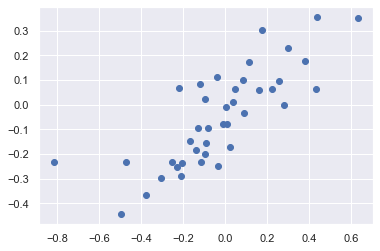

In [256]:
rf = RFR(n_estimators=100)
rf.fit(X_train_.iloc[:,3:-1], y_train_.iloc[:,3])
yhat_rf = rf.predict(X_test_.iloc[:,3:-1])

# Compute MSE
mse_rf = np.sqrt(np.sum((y_test_.iloc[:,3] - yhat_rf)**2)) / len(y_test_.iloc[:,3])
mae_rf = np.sum(np.abs(y_test_.iloc[:,3] - yhat_rf)) / len(y_test_.iloc[:,3])
r2 = r2_score(y_test_.iloc[:,3],yhat_rf) 
print(mse_rf)
print(mae_rf)
print(r2)

# Plot Scatter Plot of error
plt.plot(y_test_.iloc[:,3], yhat_rf, 'o', label='RF')

In [257]:
# Mixed Effects Random Forest Training
mrf = MERF(fixed_effects_model=
           RFR(
               bootstrap=True, 
               ccp_alpha=0.0, 
               criterion='mse', 
               max_depth=None, 
               max_features='auto',
               max_leaf_nodes=None, 
               max_samples=None, 
               min_impurity_decrease=0.0, 
               #min_impurity_split=None, 
               min_samples_leaf=1, 
               min_samples_split=2, 
               min_weight_fraction_leaf=0.0, 
               n_estimators=300, 
               n_jobs=- 1, 
               oob_score=False, 
               random_state=None, 
               verbose=0, 
               warm_start=False))
X_train =  X_train_.iloc[:,3:-1]
Z_train = np.ones((len(X_train), 1))# X_train_.loc[:,"area_code"]#np.ones((len(X_train), 1))
clusters_train = X_train_.loc[:,"year"]
y_train = y_train_.iloc[:,3]
mrf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf.py:307] Training GLL is -425.8628654463001 at iteration 1.
INFO     [merf.py:307] Training GLL is -514.7180547747494 at iteration 2.
INFO     [merf.py:307] Training GLL is -517.055203814462 at iteration 3.
INFO     [merf.py:307] Training GLL is -519.0565549459692 at iteration 4.
INFO     [merf.py:307] Training GLL is -523.8280681715776 at iteration 5.
INFO     [merf.py:307] Training GLL is -524.3051967998713 at iteration 6.
INFO     [merf.py:307] Training GLL is -520.8338649308998 at iteration 7.
INFO     [merf.py:307] Training GLL is -524.4980106908233 at iteration 8.
INFO     [merf.py:307] Training GLL is -521.8835359421789 at iteration 9.
INFO     [merf.py:307] Training GLL is -526.8814103131485 at iteration 10.
INFO     [merf.py:307] Training GLL is -522.3149078625304 at iteration 11.
INFO     [merf.py:307] Training GLL is -525.1974761110432 at iteration 12.
INFO     [merf.py:307] Training GLL is -523.8684897836935 at iteration 13.
INFO     [merf.py:307] Training GLL

In [258]:
# Mixed Effects Random Forest Test
X_test =  X_test_.iloc[:,3:-1]
Z_test = np.ones((len(X_test), 1))
clusters_test = X_test_.loc[:,"year"]
yhat_mrf = mrf.predict(X_test, Z_test, clusters_test)

Text(0.5, 1.0, 'MSE RF = 0.620, MSE MERF = 0.609')

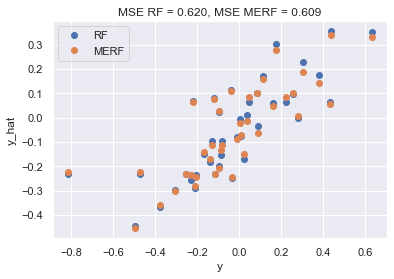

In [260]:
mse_mrf = np.sqrt(np.sum((y_test_.iloc[:,3] - yhat_mrf)**2)) / len(y_test_.iloc[:,3])
mae_mrf = np.sum(np.abs(y_test_.iloc[:,3] - yhat_mrf)) / len(y_test_.iloc[:,3])
r2_mrf = r2_score(y_test_.iloc[:,3],yhat_mrf) 

# Plot Scatter Plot of error
plt.plot(y_test_.iloc[:,3], yhat_rf, 'o', label='RF')
plt.plot(y_test_.iloc[:,3], yhat_mrf, 'o', label='MERF')
plt.grid('on')
plt.xlabel('y')
plt.ylabel('y_hat')

plt.legend()
plt.title('MSE RF = {:.3f}, MSE MERF = {:.3f}'.format(r2, r2_mrf))

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train.iloc[:,3:], y_train.iloc[:,3])
yhat_rf = rf.predict(y_test.iloc[:,3])

# Mixed Effects Random Forest Training
mrf = MERF(n_estimators=100, max_iterations=20)
X_train =  train[['Days']]
Z_train = np.ones((len(X_train), 1))
clusters_train = train['Subject']
y_train = train['Reaction']
mrf.fit(X_train, Z_train, clusters_train, y_train)

# Mixed Effects Random Forest Test
X_test =  test[['Days']]
Z_test = np.ones((len(X_test), 1))
clusters_test = test['Subject']
yhat_mrf = mrf.predict(X_test, Z_test, clusters_test)

# Compute MSE
mse_rf = np.sqrt(np.sum((y - yhat_rf)**2)) / len(y)
mse_mrf = np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y)

# Plot Scatter Plot of error
plt.plot(y, yhat_rf, 'o', label='RF')
plt.plot(y, yhat_mrf, 'o', label='MERF')
plt.grid('on')
plt.xlabel('y')
plt.ylabel('y_hat')

plt.legend()
plt.title('MSE RF = {:.3f}, MSE MERF = {:.3f}'.format(mse_rf, mse_mrf))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

class Classifier:

    def __init__(self, **kwargs) -> None:
        self.x_train = kwargs['x_train']
        self.x_test = kwargs['x_test']
        self.y_train = kwargs['y_train']
        self.y_test = kwargs['y_test']
        self.z_train = kwargs['z_train']
        self.clusters_train = kwargs['clusters_train']
        self.clusters_test = kwargs['clusters_test']
        self._train()
        pass

    # 最適化
    def _optimize(self, trial) -> np.ndarray:
    
        # Definition of space search
        bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
        ccp_alpha = trial.suggest_float('ccp_alpha',0,1)
        max_depth = trial.suggest_int('max_depth', 1, 1000)
        max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])#
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2,1000)
        # n_estimators =  trial.suggest_int('n_estimators', 1, 1000)
        min_samples_split = trial.suggest_int('min_samples_split',2,5)
        min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)

        # Classifier definition
        model = MERF(fixed_effects_model=
           RFR(
               bootstrap= bootstrap,#True, 
               ccp_alpha=ccp_alpha, 
               # criterion='mse', 
               max_depth= max_depth, 
               max_features= max_features,#'auto',
               max_leaf_nodes=max_leaf_nodes,
               max_samples=None, 
               min_impurity_decrease=0.0, 
               min_samples_leaf=min_samples_leaf,
               min_samples_split=min_samples_split, 
               min_weight_fraction_leaf=0.0, 
               n_estimators=10000,
               n_jobs=- 1, 
               oob_score=False, 
               random_state=None, 
               verbose=0, 
               warm_start=False))
        
#         model = RandomForestRegressor(bootstrap = bootstrap, #criterion = criterion,
#                                  max_depth = max_depth, #max_features = max_features,
#                                  max_leaf_nodes = max_leaf_nodes,n_estimators = n_estimators,
#                                  min_samples_split = min_samples_split,min_samples_leaf = min_samples_leaf,
#                                  n_jobs=2)

        # Definition of k-fold cross validation
        k_fold = KFold(n_splits=3)
        for train_idx, test_idx in k_fold.split(self.x_train.values, self.y_train.values):          
            # Training fold
            x_train = self.x_train.values[train_idx]
            y_train = self.y_train.values[train_idx]           
            # Testing fold
            x_test = self.x_train.values[test_idx]
            y_test = self.y_train.values[test_idx]

            # Training
            model.fit(x_train, Z_train, clusters_train, y_train)

            # Save accuracy
            predicted = model.predict(x_test)
            MAE = np.sum(np.abs(y_test - yhat_mrf)) / len(y_test)
            #np.sqrt(mean_squared_error(y_test, predicted))
        
        return MAE

    def _train(self) -> None:
        
        # Hyperparameter Optimization
        study = optuna.create_study()
        study.optimize(self._optimize, timeout=3600)

        # Train with optimal paramters
        self.model = RandomForestRegressor(n_estimators=study.best_params['n_estimators'],
                                            bootstrap = study.best_params['bootstrap'],
                                            max_depth = study.best_params['max_depth'], 
                                            #criterion="RMSE",
                                            #max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
                                            max_leaf_nodes = study.best_params['max_leaf_nodes'],
                                            min_samples_split = study.best_params['min_samples_split'],
                                            min_samples_leaf = study.best_params['min_samples_leaf'])
        
        self.model.fit(self.x_train, self.y_train)

In [ ]:
classifier = Classifier(x_train = X_train_.iloc[:,3:-1], 
                        x_test = X_val_.iloc[:,3:-1], 
                        y_train = y_train_.iloc[:,3], 
                        y_test = y_val_.iloc[:,3],
                        z_train = np.ones((len(X_train_), 1)),
                        z_test = np.ones((len(X_test_), 1)),
                        clusters_train = X_train_.loc[:,"year"],
                        clusters_test = X_test_.loc[:,"year"]
                       )

[I 2021-08-30 14:42:51,685] A new study created in memory with name: no-name-b7f1dba8-5648-4be6-b1c0-bdea14e7f7f1
[I 2021-08-30 14:42:54,251] Trial 0 finished with value: 1.4473833789204202 and parameters: {'bootstrap': 'True', 'max_depth': 859, 'max_leaf_nodes': 696, 'n_estimators': 362, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 1.4473833789204202.
[I 2021-08-30 14:42:59,138] Trial 1 finished with value: 1.4737839685110068 and parameters: {'bootstrap': 'True', 'max_depth': 968, 'max_leaf_nodes': 74, 'n_estimators': 787, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 1.4473833789204202.
[I 2021-08-30 14:43:03,386] Trial 2 finished with value: 1.4478130915887715 and parameters: {'bootstrap': 'True', 'max_depth': 576, 'max_leaf_nodes': 744, 'n_estimators': 693, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 1.4473833789204202.
[I 2021-08-30 14:43:05,917] Trial 3 finished with value: 1.199569836734

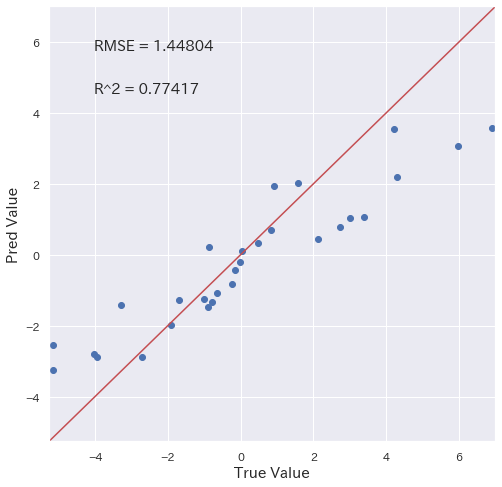

In [ ]:
#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred']) 
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)
    plt.show()


#モデル評価用データで予測値出力
predicted = classifier.model.predict(X_test)
 
#可視化関数にぶち込めるように予測値と正答値をデータフレームに加工
pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(predicted)], axis=1)
pred_df.columns = ['true', 'pred']
 
#可視化関数を実行
True_Pred_map(pred_df)

Text(0.1, 0.8, 'R^2 = 0.77417')

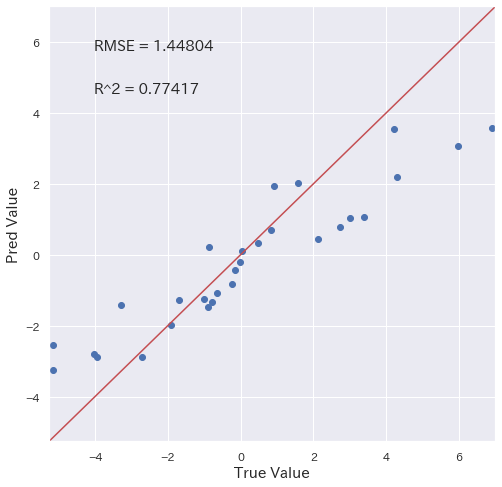

In [ ]:
RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
R2 = r2_score(pred_df['true'], pred_df['pred']) 
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter('true', 'pred', data=pred_df)
ax.set_xlabel('True Value', fontsize=15)
ax.set_ylabel('Pred Value', fontsize=15)
ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
y = x
ax.plot(x,y,'r-')
plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)


In [ ]:
cols = list(df_md.drop(['30_34歳女性人口'],axis=1).columns) 

f_importance = np.array(classifier.model.feature_importances_) # 特徴量重要度の算出 //
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

feature  importance
122  特化係数_就業者数女_Ｌ学術研究_専門_技術サービス業    0.122251
21                          婚姻件数    0.121979
60               就業者数女_Ｑ複合サービス事業    0.111910
44                   就業者数女_家族従事者    0.102505
117            特化係数_就業者数女_Ｇ情報通信業    0.068095
..                           ...         ...
152                          栃木県    0.000000
153                          群馬県    0.000000
154                          埼玉県    0.000000
155                          千葉県    0.000000
190                          沖縄県    0.000000

[191 rows x 2 columns]

In [ ]:
df_importance.to_csv('rf_08300100.csv', encoding='utf_8_sig') 

In [ ]:
import shap

# Initialize TreeExplainer
explainer = shap.TreeExplainer(classifier.model)

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_train)

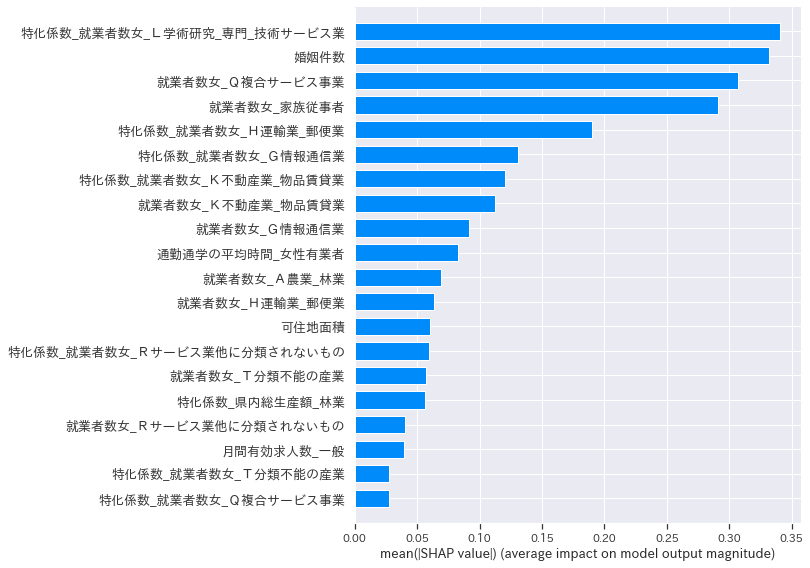

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X, plot_type="bar",show=False)
plt.savefig('grafico.png')

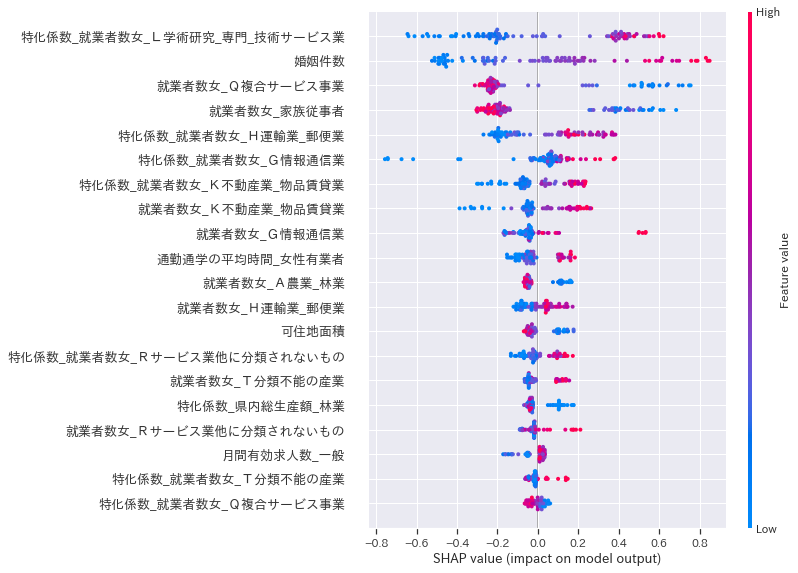

In [ ]:
shap.summary_plot(shap_values, X_train)

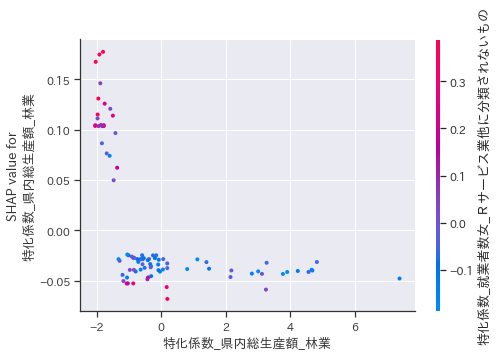

In [ ]:
shap.dependence_plot("特化係数_県内総生産額_林業",shap_values, X_train)

In [ ]:
#plt.show()
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[4,:])

In [ ]:
shap.initjs()
shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[:,:], features=X_train.columns)

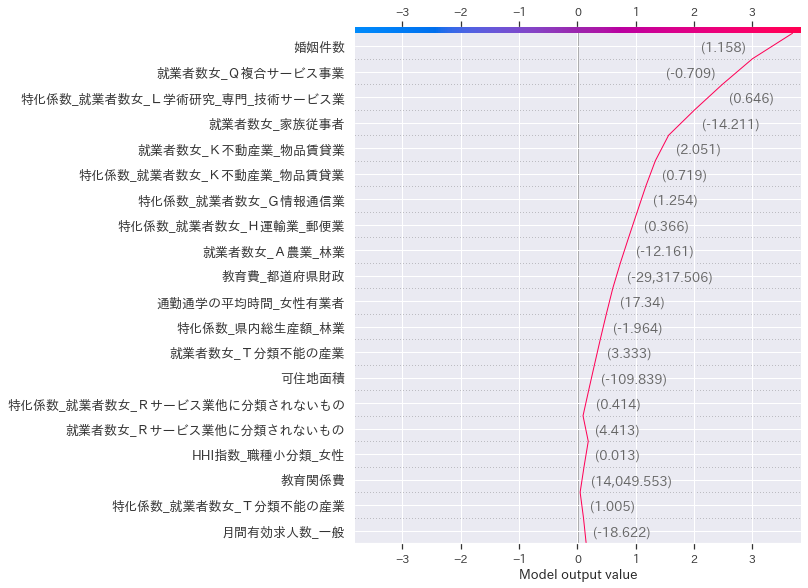

In [ ]:
import japanize_matplotlib
shap.decision_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[80,:])

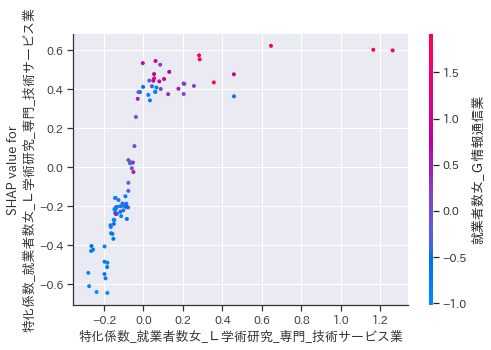

In [ ]:
shap.dependence_plot("特化係数_就業者数女_Ｌ学術研究_専門_技術サービス業", shap_values, X_train)

In [ ]:
shap.plots.scatter(shap_values[1,"Relationship"], color=shap_values)

IndexError: ignored

In [ ]:
shap_values.shape

(89, 191)

In [ ]:
shap_values.shape

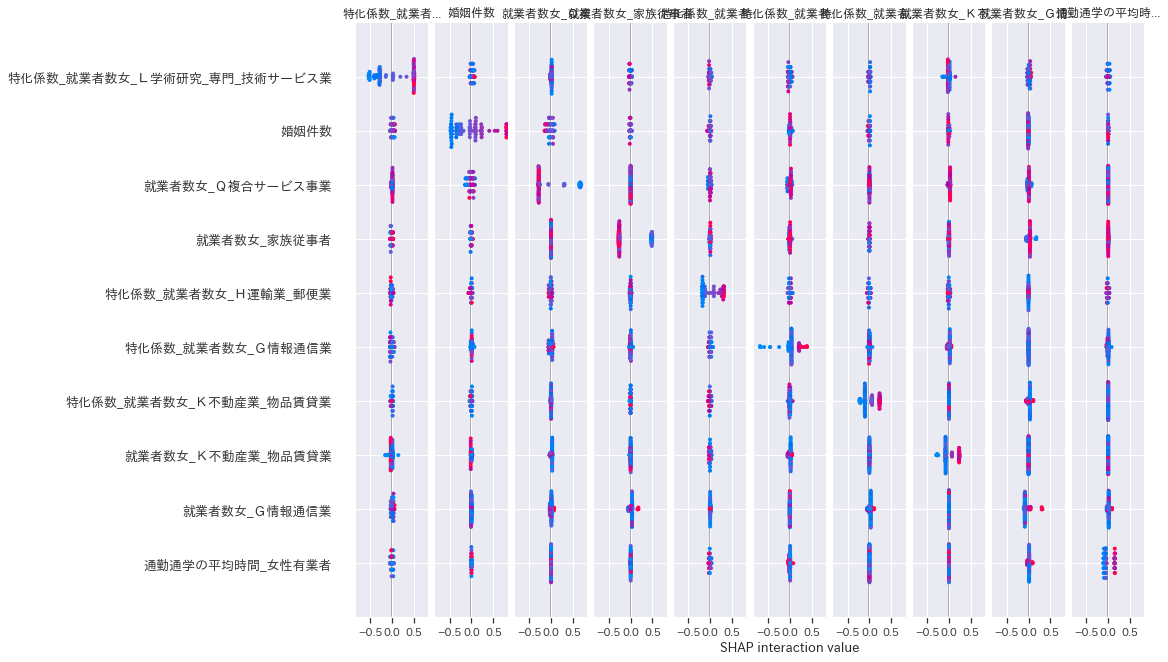

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, features=X_train, max_display=10)

## lasso

In [229]:
sparce_df = pd.read_excel("/Users/ShuntaroMiwa/00_python/(edit)compe2021/20220113/output_ori20220114.xlsx").fillna(0)
sparce_df = sparce_df.rename(columns={2015: '2015'})
sparce_df = sparce_df.query('women == 1 & inout == "転出" & year == 2015')  #& age == "15～19歳"')
sparce_df

sex  women     age  15～19歳  20～24歳  25～29歳 inout  out  year  2015  ...  \
893    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2015   1.0  ...   
894    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2015   1.0  ...   
895    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2015   1.0  ...   
896    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2015   1.0  ...   
897    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2015   1.0  ...   
...   ..    ...     ...     ...     ...     ...   ...  ...   ...   ...  ...   
1499   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   
1500   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   
1501   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   
1502   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   
1503   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   

      愛媛県  高知県  福岡県  佐賀県  長崎県  熊本県  大分県  宮崎県  鹿児島県  沖縄県  
893   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
894   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
895   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
896   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
897   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  
1499  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   0.0  0.0  
1500  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  
1501  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   0.0  0.0  
1502  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0  0.0  
1503  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  1.0  

[188 rows x 207 columns]

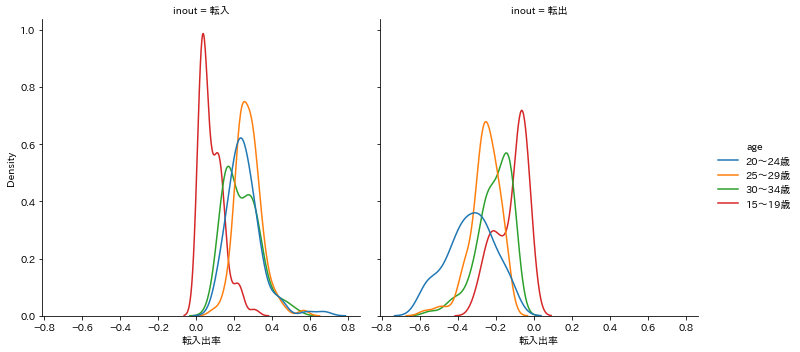

In [17]:
sns.displot(data = sparce_df, x = '転入出率', col="inout", hue = 'age',kind="kde")

In [4]:
sparce_df

sex  women     age  15～19歳  20～24歳  25～29歳 inout  out  year  2015  ...  \
329    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2010   0.0  ...   
330    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2010   0.0  ...   
331    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2010   0.0  ...   
332    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2010   0.0  ...   
333    女    1.0  20～24歳     0.0     1.0     0.0    転出  1.0  2010   0.0  ...   
...   ..    ...     ...     ...     ...     ...   ...  ...   ...   ...  ...   
1499   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   
1500   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   
1501   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   
1502   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   
1503   女    1.0  15～19歳     1.0     0.0     0.0    転出  1.0  2015   1.0  ...   

      愛媛県  高知県  福岡県  佐賀県  長崎県  熊本県  大分県  宮崎県  鹿児島県  沖縄県  
329   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
330   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
331   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
332   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
333   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  
1499  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   0.0  0.0  
1500  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  
1501  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   0.0  0.0  
1502  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0  0.0  
1503  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  1.0  

[376 rows x 207 columns]

In [230]:
# 説明変数のリスト
exog = sparce_df.iloc[:,16:160].columns.tolist()
exog

['共働き世帯数',
 '完全失業者数',
 '非労働力人口女',
 '一般世帯数_総数',
 '一般世帯数_父子母子世帯',
 '一般世帯数_３世代世帯',
 '婚姻件数',
 '離婚件数',
 '平均婚姻年齢_初婚の妻',
 '現に保護を受けた生活保護被保護実世帯数【世帯】',
 '要保護_準要保護児童生徒数合計',
 '大学・短大数',
 '専修学校数',
 '大学・短大学生数',
 '専修学校生徒数',
 '女性の高等学校卒業者のうち進学者数',
 '女性の高等学校卒業者のうち就職者数',
 '幼稚園定員数',
 '保育所等定員数',
 '一般診療所数',
 '教育費_都道府県財政',
 '女性の地元就職進学者数',
 '女性の流入大学・短大進学者総数',
 '女性の流出大学・短大進学者総数',
 '月間有効求人数_一般',
 '県内総生産額_農林業',
 '県内総生産額_水産業',
 '県内総生産額_鉱業',
 '県内総生産額_製造業',
 '県内総生産額_建設業',
 '県内総生産額_電気_ガス_水道_廃棄物処理業',
 '県内総生産額_卸売_小売業',
 '県内総生産額_金融_保険業',
 '県内総生産額_不動産業',
 '県内総生産額_運輸_郵便業',
 '県内総生産額_情報通信業',
 '県内総生産額_公務',
 '民営事業所数',
 '民営事業所数従業者３００人以上',
 '従業者数_民営事業所',
 '従業者数_民営事業所300人以上',
 '可住地面積',
 '映画館、劇場、音楽会場等の数',
 'ガソリン販売量',
 '就業者数女',
 '就業者数女_家族従事者',
 '就業者数女_Ａ農業_林業',
 '就業者数女_Ｂ漁業',
 '就業者数女_Ｄ建設業',
 '就業者数女_Ｅ製造業',
 '就業者数女_Ｆ電気_ガス_熱供給_水道業',
 '就業者数女_Ｇ情報通信業',
 '就業者数女_Ｈ運輸業_郵便業',
 '就業者数女_Ｉ卸売業_小売業',
 '就業者数女_Ｊ金融業_保険業',
 '就業者数女_Ｋ不動産業_物品賃貸業',
 '就業者数女_Ｌ学術研究_専門_技術サービス業',
 '就業者数女_Ｍ宿泊業_飲食サービス業',
 '就業者数女_Ｎ生活関連サービス業_娯楽業',
 '就業者数女_О教育_学習支援業',
 '就業者数女_Ｐ医療_福祉'

In [231]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()

# 使う変数だけで構成されるDataFrame
df = sparce_df.loc[:,['age', 'year']+exog]# 目的変数及び'area_code'は除外

# varの平均からの乖離を計算
df_g = df.groupby(['age','year'])# 'area_code'は除外
df_mean = df_g[exog].transform('mean')
df_md = df.loc[:,exog]-df_mean

# columns = df_md.columns
# index = df_md.index
# df_md = ss.fit_transform(df_md)

# df_md = pd.DataFrame(df_md).set_axis(columns, axis=1).set_index(index)
df_md

共働き世帯数    完全失業者数    非労働力人口女   一般世帯数_総数  一般世帯数_父子母子世帯  一般世帯数_３世代世帯  \
893  -62.598166  1.179330  17.797171  51.170451      0.822533   -46.028712   
894    1.774133  6.102126  15.598568 -12.632634      8.487152    31.567511   
895   24.360654 -0.080703   7.602773 -19.429976      3.411194    43.971558   
896  -27.880604  2.895226   0.986965   1.978482     -1.251342    12.552589   
897   27.783036  0.659865  29.494464 -23.243492      1.361394    55.616540   
...         ...       ...        ...        ...           ...          ...   
1499   8.886515  1.410915   1.699371  -8.545733      5.046704     1.381729   
1500 -13.856903  1.575241  17.215389  13.950535      0.431786   -19.860763   
1501   4.523815  1.930588   2.775359  16.016946      8.119080   -31.703286   
1502 -23.447614  2.066903  12.186912  36.403697      2.711380   -52.119573   
1503 -49.803311  6.998560 -43.489886 -11.795075     14.522647   -33.136459   

          婚姻件数      離婚件数  平均婚姻年齢_初婚の妻  現に保護を受けた生活保護被保護実世帯数【世帯】  ...  \
893   0.082742  0.353256     0.148936                24.013010  ...   
894  -0.496941  0.002927    -0.151064                20.266238  ...   
895  -0.551612 -0.201292    -0.151064                -5.101487  ...   
896   0.199962 -0.021602     0.148936                -4.836455  ...   
897  -1.117647 -0.230565     0.148936                 3.557988  ...   
...        ...       ...          ...                      ...  ...   
1499 -0.030744  0.112028    -0.151064                 2.139245  ...   
1500 -0.092007  0.041454    -0.151064                 6.292637  ...   
1501 -0.083167  0.360547    -0.451064                 4.032981  ...   
1502  0.037385  0.141863    -0.151064                 6.495677  ...   
1503  1.416289  0.783411    -0.151064                20.681853  ...   

      特化係数_従業者数女_Ｃ事務従事者  特化係数_従業者数女_Ｄ販売従事者  特化係数_従業者数女_Ｅサービス職業従事者  \
893           -0.085944           0.008157               0.051576   
894           -0.174223          -0.022167               0.010706   
895           -0.123361          -0.041811              -0.008973   
896            0.121022           0.123112              -0.055862   
897           -0.092996          -0.018987               0.094516   
...                 ...                ...                    ...   
1499          -0.065036          -0.038077               0.037024   
1500          -0.085568           0.024891               0.094979   
1501          -0.082498          -0.098624               0.041146   
1502          -0.086880          -0.016390               0.109654   
1503           0.060688          -0.038079               0.031684   

      特化係数_従業者数女_Ｆ保安職業従事者  特化係数_従業者数女_Ｇ農林漁業従事者  特化係数_従業者数女_Ｈ生産工程従事者  \
893              0.467731             0.457742            -0.323002   
894              0.632052             2.034747            -0.014736   
895             -0.233604             1.526170             0.229546   
896              0.413175            -0.354994            -0.105717   
897             -0.344122             0.907487             0.204712   
...                   ...                  ...                  ...   
1499             0.037958             1.000071            -0.179055   
1500            -0.122407             0.254033            -0.209416   
1501             0.001306             1.299680            -0.044789   
1502            -0.198744             0.671716            -0.110485   
1503             0.338734            -0.745587            -0.565834   

      特化係数_従業者数女_Ｉ輸送_機械運転従事者  特化係数_従業者数女_Ｊ建設_採掘従事者  特化係数_従業者数女_Ｋ運搬_清掃_包装等従事者  \
893                 0.068415             -0.133498                  0.257886   
894                -0.030988              0.166362                  0.129279   
895                 0.117670              0.337567                  0.068047   
896                 0.350552              0.411231                  0.001775   
897                -0.104254             -0.250407                 -0.014645   
...                      ...                   ...       

In [28]:
df_mean.head()

共働き世帯数     完全失業者数     非労働力人口女    一般世帯数_総数  一般世帯数_父子母子世帯  \
1363  274.044403  32.479243  220.054905  386.260698     28.227423   
1364  274.044403  32.479243  220.054905  386.260698     28.227423   
1365  274.044403  32.479243  220.054905  386.260698     28.227423   
1366  274.044403  32.479243  220.054905  386.260698     28.227423   
1367  274.044403  32.479243  220.054905  386.260698     28.227423   

      一般世帯数_３世代世帯      婚姻件数      離婚件数  平均婚姻年齢_初婚の妻  現に保護を受けた生活保護被保護実世帯数【世帯】  \
1363    96.925989  5.055501  1.886901    28.529787                23.696525   
1364    96.925989  5.055501  1.886901    28.529787                23.696525   
1365    96.925989  5.055501  1.886901    28.529787                23.696525   
1366    96.925989  5.055501  1.886901    28.529787                23.696525   
1367    96.925989  5.055501  1.886901    28.529787                23.696525   

      ...  特化係数_従業者数女_Ｃ事務従事者  特化係数_従業者数女_Ｄ販売従事者  特化係数_従業者数女_Ｅサービス職業従事者  \
1363  ...            0.59542           0.557274               0.616298   
1364  ...            0.59542           0.557274               0.616298   
1365  ...            0.59542           0.557274               0.616298   
1366  ...            0.59542           0.557274               0.616298   
1367  ...            0.59542           0.557274               0.616298   

      特化係数_従業者数女_Ｆ保安職業従事者  特化係数_従業者数女_Ｇ農林漁業従事者  特化係数_従業者数女_Ｈ生産工程従事者  \
1363             0.473244             0.764757              0.62367   
1364             0.473244             0.764757              0.62367   
1365             0.473244             0.764757              0.62367   
1366             0.473244             0.764757              0.62367   
1367             0.473244             0.764757              0.62367   

      特化係数_従業者数女_Ｉ輸送_機械運転従事者  特化係数_従業者数女_Ｊ建設_採掘従事者  特化係数_従業者数女_Ｋ運搬_清掃_包装等従事者  \
1363                0.482136              0.563181                  0.539816   
1364                0.482136              0.563181                  0.539816   
1365                0.482136              0.563181                  0.539816   
1366                0.482136              0.563181                  0.539816   
1367                0.482136              0.563181                  0.539816   

      特化係数_従業者数女_Ｌ分類不能の職業  
1363             0.419303  
1364             0.419303  
1365             0.419303  
1366             0.419303  
1367             0.419303  

[5 rows x 144 columns]

In [232]:
X = pd.concat([sparce_df.loc[:, ['15～19歳','20～24歳','25～29歳']], df_md.iloc[:,0:]], axis=1).fillna(0)#, sparce_df.iloc[:,160:]], axis=1).fillna(0)
# y = sparce_df.loc[:,'転入出率']
y =  np.sign(sparce_df.loc[:,'転入出率']) * np.log(np.abs(sparce_df.loc[:,'転入出率']))
columns = X.columns
y.tail()

1499    1.564376
1500    1.475500
1501    1.330004
1502    1.566493
1503    1.788532
Name: 転入出率, dtype: float64

In [233]:
X.head()

15～19歳  20～24歳  25～29歳     共働き世帯数    完全失業者数    非労働力人口女   一般世帯数_総数  \
893     0.0     1.0     0.0 -62.598166  1.179330  17.797171  51.170451   
894     0.0     1.0     0.0   1.774133  6.102126  15.598568 -12.632634   
895     0.0     1.0     0.0  24.360654 -0.080703   7.602773 -19.429976   
896     0.0     1.0     0.0 -27.880604  2.895226   0.986965   1.978482   
897     0.0     1.0     0.0  27.783036  0.659865  29.494464 -23.243492   

     一般世帯数_父子母子世帯  一般世帯数_３世代世帯      婚姻件数  ...  特化係数_従業者数女_Ｃ事務従事者  \
893      0.822533   -46.028712  0.082742  ...          -0.085944   
894      8.487152    31.567511 -0.496941  ...          -0.174223   
895      3.411194    43.971558 -0.551612  ...          -0.123361   
896     -1.251342    12.552589  0.199962  ...           0.121022   
897      1.361394    55.616540 -1.117647  ...          -0.092996   

     特化係数_従業者数女_Ｄ販売従事者  特化係数_従業者数女_Ｅサービス職業従事者  特化係数_従業者数女_Ｆ保安職業従事者  \
893           0.008157               0.051576             0.467731   
894          -0.022167               0.010706             0.632052   
895          -0.041811              -0.008973            -0.233604   
896           0.123112              -0.055862             0.413175   
897          -0.018987               0.094516            -0.344122   

     特化係数_従業者数女_Ｇ農林漁業従事者  特化係数_従業者数女_Ｈ生産工程従事者  特化係数_従業者数女_Ｉ輸送_機械運転従事者  \
893             0.457742            -0.323002                0.068415   
894             2.034747            -0.014736               -0.030988   
895             1.526170             0.229546                0.117670   
896            -0.354994            -0.105717                0.350552   
897             0.907487             0.204712               -0.104254   

     特化係数_従業者数女_Ｊ建設_採掘従事者  特化係数_従業者数女_Ｋ運搬_清掃_包装等従事者  特化係数_従業者数女_Ｌ分類不能の職業  
893             -0.133498                  0.257886             0.325882  
894              0.166362                  0.129279            -0.139559  
895              0.337567                  0.068047            -0.463595  
896              0.411231                  0.001775            -0.277386  
897             -0.250407                 -0.014645            -0.433016  

[5 rows x 147 columns]

In [234]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()

# print(ss.fit_transform(l))
# ValueError: Expected 2D array, got 1D array instead:

X = ss.fit_transform(X)
X

array([[-0.57735027,  1.73205081, -0.57735027, ..., -0.43368174,
         2.30926622,  0.80663323],
       [-0.57735027,  1.73205081, -0.57735027, ...,  0.54044604,
         1.1576472 , -0.34544063],
       [-0.57735027,  1.73205081, -0.57735027, ...,  1.09662535,
         0.6093348 , -1.14750465],
       ...,
       [ 1.73205081, -0.57735027, -0.57735027, ...,  0.53097598,
        -0.62091144, -0.73041246],
       [ 1.73205081, -0.57735027, -0.57735027, ...,  0.0327205 ,
        -0.43509408, -0.89101955],
       [ 1.73205081, -0.57735027, -0.57735027, ..., -1.10460058,
        -0.22811934,  2.15012343]])

In [235]:
X = pd.DataFrame(X)
X = X.set_axis(columns, axis=1)#.drop('out', axis=1)
X

15～19歳    20～24歳   25～29歳    共働き世帯数    完全失業者数   非労働力人口女  一般世帯数_総数  \
0   -0.577350  1.732051 -0.57735 -1.517877  0.442623  1.139835  1.827060   
1   -0.577350  1.732051 -0.57735  0.043019  2.290236  0.999024 -0.451053   
2   -0.577350  1.732051 -0.57735  0.590696 -0.030289  0.486926 -0.693755   
3   -0.577350  1.732051 -0.57735 -0.676047  1.086630  0.063211  0.070642   
4   -0.577350  1.732051 -0.57735  0.673681  0.247659  1.888999 -0.829918   
..        ...       ...      ...       ...       ...       ...       ...   
183  1.732051 -0.577350 -0.57735  0.215480  0.529541  0.108838 -0.305129   
184  1.732051 -0.577350 -0.57735 -0.336001  0.591216  1.102575  0.498109   
185  1.732051 -0.577350 -0.57735  0.109693  0.724584  0.177750  0.571891   
186  1.732051 -0.577350 -0.57735 -0.568556  0.775745  0.780521  1.299808   
187  1.732051 -0.577350 -0.57735 -1.207628  2.626683 -2.785348 -0.421148   

     一般世帯数_父子母子世帯  一般世帯数_３世代世帯      婚姻件数  ...  特化係数_従業者数女_Ｃ事務従事者  \
0        0.176751    -1.254879  0.166497  ...          -0.975388   
1        1.823770     0.860624 -0.999967  ...          -1.977272   
2        0.733018     1.198795 -1.109978  ...          -1.400030   
3       -0.268896     0.342221  0.402373  ...           1.373484   
4        0.292544     1.516271 -2.248978  ...          -1.055420   
..            ...          ...       ...  ...                ...   
183      1.084466     0.037670 -0.061864  ...          -0.738099   
184      0.092785    -0.541463 -0.185141  ...          -0.971119   
185      1.744676    -0.864325 -0.167353  ...          -0.936277   
186      0.582638    -1.420934  0.075227  ...          -0.986005   
187      3.120713    -0.903398  2.849920  ...           0.688750   

     特化係数_従業者数女_Ｄ販売従事者  特化係数_従業者数女_Ｅサービス職業従事者  特化係数_従業者数女_Ｆ保安職業従事者  \
0             0.132310               0.809324             1.810929   
1            -0.359559               0.168005             2.447133   
2            -0.678208              -0.140806            -0.904452   
3             1.996955              -0.876574             1.599700   
4            -0.307978               1.483143            -1.332346   
..                 ...                    ...                  ...   
183          -0.617634               0.580975             0.146964   
184           0.403751               1.490394            -0.473928   
185          -1.599747               0.645661             0.005056   
186          -0.265851               1.720683            -0.769481   
187          -0.617656               0.497183             1.311486   

     特化係数_従業者数女_Ｇ農林漁業従事者  特化係数_従業者数女_Ｈ生産工程従事者  特化係数_従業者数女_Ｉ輸送_機械運転従事者  \
0               0.543598            -1.066276                0.297999   
1               2.416388            -0.048647               -0.134978   
2               1.812421             0.757763                0.512542   
3              -0.421578            -0.348987                1.526918   
4               1.077697             0.675783               -0.454103   
..                   ...                  ...                     ...   
183             1.187646            -0.591086               -0.733104   
184             0.301680            -0.691312               -0.868544   
185             1.543450            -0.147856                0.130363   
186             0.797705            -0.364729               -0.492604   
187            -0.885431            -1.867900                1.639873   

     特化係数_従業者数女_Ｊ建設_採掘従事者  特化係数_従業者数女_Ｋ運搬_清掃_包装等従事者  特化係数_従業者数女_Ｌ分類不能の職業  
0               -0.433682                  2.309266             0.806633  
1                0.540446                  1.157647            -0.345441  
2                1.096625                  0.609335            -1.147505  
3                1.335929                  0.015896            -0.686594  
4               -0.813475                 -0.131138            -1.071816  
..                    ...                       ...                  ...  
183              1.180767         

In [333]:
# 女性のみ
X = X.query('women == 1')
X = X.iloc[:,1:]
X

2015    共働き世帯数    完全失業者数   非労働力人口女  一般世帯数_総数  一般世帯数_父子母子世帯  一般世帯数_３世代世帯  \
94   -1.0 -1.461867  0.614550  1.312537  1.841825      0.507720    -1.414619   
95    1.0 -1.484754  0.295273  1.155683  1.780982      0.166751    -1.132841   
96   -1.0 -0.022340  3.368909  1.029552 -0.482533      2.288299     0.845838   
97    1.0  0.042080  1.527812  1.012913 -0.439678      1.720588     0.776927   
98   -1.0  0.513091  0.908555  0.677442 -0.809543      0.737921     1.325262   
..    ...       ...       ...       ...       ...           ...          ...   
183   1.0  0.107299  0.483369  0.180222  0.557468      1.645970    -0.780269   
184  -1.0 -0.576770  0.248071  0.843256  1.391565      0.403899    -1.603576   
185   1.0 -0.556149  0.517498  0.791373  1.267027      0.549674    -1.282747   
186  -1.0 -1.198105  4.751310 -1.898898 -0.469961      3.439609    -1.027842   
187   1.0 -1.181275  1.752256 -2.824073 -0.410526      2.944156    -0.815542   

         婚姻件数      離婚件数  平均婚姻年齢_初婚の妻  ...  香川県  愛媛県  高知県  福岡県  佐賀県  長崎県  熊本県  \
94   0.189886  1.921743     0.457427  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
95   0.156931  1.694581     0.400248  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
96  -1.407158  0.306140    -1.155003  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
97  -0.942512  0.014043    -0.405966  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
98  -1.426676 -0.659452    -0.886264  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..        ...       ...          ...  ...  ...  ...  ...  ...  ...  ...  ...   
183 -0.157737  1.729556    -1.212181  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
184  0.062350  0.305014    -0.886264  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
185  0.070905  0.680522    -0.405966  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
186  2.520005  3.278423    -0.348788  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
187  2.686171  3.758049    -0.405966  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     大分県  宮崎県  鹿児島県  
94   0.0  0.0   0.0  
95   0.0  0.0   0.0  
96   0.0  0.0   0.0  
97   0.0  0.0   0.0  
98   0.0  0.0   0.0  
..   ...  ...   ...  
183  0.0  0.0   0.0  
184  0.0  0.0   0.0  
185  0.0  0.0   0.0  
186  0.0  0.0   0.0  
187  0.0  0.0   0.0  

[94 rows x 191 columns]

In [335]:
# 女性のみ
y = sparce_df.query('women == 1').loc[:,'転入超過率']
y

94    -0.063490
95    -0.028727
96    -0.425605
97    -0.495007
98    -0.240349
         ...   
183   -0.379777
184   -0.217378
185   -0.268600
186    0.021108
187   -0.089218
Name: 転入超過率, Length: 94, dtype: float64

In [33]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20,  shuffle=True)#ランダム固定、0の数字には意味はない
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20,  shuffle=True)

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,  shuffle=True)

In [237]:
## 交互作用
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias = False)
X_trainp = poly.fit_transform(X_train)
X_testp = poly.fit_transform(X_test)

In [246]:
X_trainp.shape
y = y - y.mean()

In [256]:
# 素

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error as mae

model = ElasticNet(alpha=0.01)
model.fit(X_trainp, y_train)

y_pred = model.predict(X_testp)

print(f'mae: {mae(y_pred, y_test)}')
print(f'r2: {r2_score(y_pred, y_test)}')

mae: 0.1658236063982769
r2: 0.659996354795255


In [254]:
print(f'coefficient: {model.coef_}')

coefficient: [ 2.50102960e-01 -1.18920330e-01 -5.94091525e-03 ... -2.62382202e-09
  3.32403831e-09 -7.02411528e-10]


In [244]:
cols = poly.get_feature_names(X_train.columns)
f_importance = np.array(model.coef_) # 特徴量重要度の算出 //
# f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

feature  importance
0                    15～19歳    0.182590
387         20～24歳 所定内給与額_女    0.076450
242         15～19歳 所定内給与額_女    0.064047
237  15～19歳 通勤通学の平均時間_女性有業者    0.051227
293           20～24歳 25～29歳    0.038903
..                      ...         ...
190            15～19歳 可住地面積   -0.019873
66    就業者数女_Ｓ公務他に分類されるものを除く   -0.031013
19        女性の高等学校卒業者のうち就職者数   -0.031221
210  15～19歳 就業者数女_Ｑ複合サービス事業   -0.052678
1                    20～24歳   -0.099166

[10878 rows x 2 columns]

In [245]:
df_importance.to_csv('df_importance_women15_out_20220116.csv', encoding='utf_8_sig')

In [74]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error as mae

class e_net:
    def __init__(self, **kwargs) -> None:
        self.x_train = kwargs['x_train']
        self.y_train = kwargs['y_train']
        self._train()
        pass
    
    def _optimize(self, trial) :
        # alpha をsuggest（提案）する範囲の指定
        alpha = trial.suggest_loguniform("alpha", 0.001, 10.0)
        l1 = trial.suggest_uniform("l1", 0.001, 1.0)
        model = ElasticNet(alpha = alpha,
                        l1_ratio = l1,
                        random_state = 2021,
                        max_iter = 1000)
        # 評価関数は平均２乗誤差の交差平均とする
        
        k_fold = KFold(n_splits=3)
        for train_idx, test_idx in k_fold.split(self.x_train, self.y_train.values):          
            # Training fold
            x_train = self.x_train[train_idx]
            y_train = self.y_train.values[train_idx]           
            # Testing fold
            x_test = self.x_train[test_idx]
            y_test = self.y_train.values[test_idx]

            # Training
            model.fit(x_train, y_train)

            # Save accuracy
            predicted = model.predict(x_test)
            MAE = np.sum(np.abs(y_test - predicted)) / len(y_test)
        return MAE      
        # return cross_val_score(reg, self.x_train, self.y_train, n_jobs=cores, cv=3, scoring = "neg_mean_squared_error").mean()

    def _train(self) -> None:       
        # Hyperparameter Optimization
        study = optuna.create_study(direction='minimize')
        study.optimize(self._optimize, n_trials=100)

        # Train with optimal paramters
        self.model = ElasticNet(alpha = study.best_params['alpha'],
                        l1_ratio = study.best_params['l1'],
                        random_state = 2021,
                        max_iter = 1000)
        
        self.model.fit(self.x_train, self.y_train)

In [125]:
classifier = e_net(x_train=X_trainp, y_train=y_train)

[I 2022-01-15 15:52:48,018] A new study created in memory with name: no-name-522129a9-fd7c-4a21-bfeb-14ead0e1708d
[I 2022-01-15 15:52:48,096] Trial 0 finished with value: 0.39395415680590307 and parameters: {'alpha': 7.225111530180677, 'l1': 0.6904804568779991}. Best is trial 0 with value: 0.39395415680590307.
[I 2022-01-15 15:52:48,274] Trial 1 finished with value: 0.2623456961942459 and parameters: {'alpha': 0.4702383752339282, 'l1': 0.11137227708996777}. Best is trial 1 with value: 0.2623456961942459.
[I 2022-01-15 15:52:50,110] Trial 2 finished with value: 0.175525709952512 and parameters: {'alpha': 0.0016790585208106643, 'l1': 0.14765926340259514}. Best is trial 2 with value: 0.175525709952512.
[I 2022-01-15 15:52:51,833] Trial 3 finished with value: 0.1852759053207205 and parameters: {'alpha': 0.0017354023150265047, 'l1': 0.5963466884047656}. Best is trial 2 with value: 0.175525709952512.
[I 2022-01-15 15:52:52,252] Trial 4 finished with value: 0.1960308553385201 and parameters: 

[I 2022-01-15 15:53:41,421] Trial 38 finished with value: 0.17808114654740034 and parameters: {'alpha': 0.007821487447917679, 'l1': 0.07091869556101982}. Best is trial 25 with value: 0.17513414944417605.
[I 2022-01-15 15:53:42,049] Trial 39 finished with value: 0.18748470681628818 and parameters: {'alpha': 0.040230622385034734, 'l1': 0.2790564027148268}. Best is trial 25 with value: 0.17513414944417605.
[I 2022-01-15 15:53:43,836] Trial 40 finished with value: 0.17211124083201113 and parameters: {'alpha': 0.0033865659230938837, 'l1': 0.17205525017451204}. Best is trial 40 with value: 0.17211124083201113.
[I 2022-01-15 15:53:45,580] Trial 41 finished with value: 0.17436084007386976 and parameters: {'alpha': 0.00405142833315635, 'l1': 0.1805565612851448}. Best is trial 40 with value: 0.17211124083201113.
[I 2022-01-15 15:53:47,313] Trial 42 finished with value: 0.17265613854462636 and parameters: {'alpha': 0.003519454040769082, 'l1': 0.17668257703638587}. Best is trial 40 with value: 0.1

[I 2022-01-15 15:54:43,353] Trial 76 finished with value: 0.17177509211183753 and parameters: {'alpha': 0.0024788452522217556, 'l1': 0.23826516644137716}. Best is trial 49 with value: 0.1704844832069643.
[I 2022-01-15 15:54:45,013] Trial 77 finished with value: 0.17546181331036842 and parameters: {'alpha': 0.0012505306176752325, 'l1': 0.39343565697373645}. Best is trial 49 with value: 0.1704844832069643.
[I 2022-01-15 15:54:46,797] Trial 78 finished with value: 0.1879602930558701 and parameters: {'alpha': 0.0018398585377991277, 'l1': 0.712370401818722}. Best is trial 49 with value: 0.1704844832069643.
[I 2022-01-15 15:54:48,633] Trial 79 finished with value: 0.17736188109790882 and parameters: {'alpha': 0.001040427552415315, 'l1': 0.347587674393734}. Best is trial 49 with value: 0.1704844832069643.
[I 2022-01-15 15:54:50,724] Trial 80 finished with value: 0.17871543579149712 and parameters: {'alpha': 0.010163827214208592, 'l1': 0.2216422479328835}. Best is trial 49 with value: 0.170484

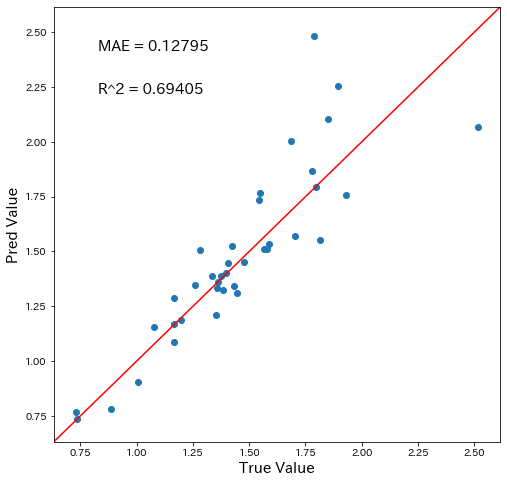

In [126]:
#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    MAE = np.sum(np.abs(pred_df['true'] - pred_df['pred'])) / len(pred_df['pred'])
    # RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred']) 
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'MAE = {}'.format(str(round(MAE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)
    plt.show()


#モデル評価用データで予測値出力
predicted = classifier.model.predict(X_testp)
# predicted = classifier.model.predict(X_testp)
 
#可視化関数にぶち込めるように予測値と正答値をデータフレームに加工
pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(predicted)], axis=1)
pred_df.columns = ['true', 'pred']
 
#可視化関数を実行
True_Pred_map(pred_df)

In [127]:
cols = poly.get_feature_names(X_train.columns)
f_importance = np.array(classifier.model.coef_) # 特徴量重要度の算出 //
# f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'coef':f_importance})
df_importance = df_importance.sort_values('coef', ascending=False) # 降順ソート
display(df_importance)

feature      coef
0                                15～19歳  0.210761
293                       20～24歳 25～29歳  0.072828
387                     20～24歳 所定内給与額_女  0.062466
181                15～19歳 県内総生産額_金融_保険業  0.034656
382              20～24歳 通勤通学の平均時間_女性有業者  0.034202
..                                  ...       ...
210              15～19歳 就業者数女_Ｑ複合サービス事業 -0.039666
19                    女性の高等学校卒業者のうち就職者数 -0.040492
251  15～19歳 特化係数_県内総生産額_電気_ガス_水道_廃棄物処理業 -0.041136
331                       20～24歳 民営事業所数 -0.052552
1                                20～24歳 -0.114728

[10878 rows x 2 columns]

In [128]:
df_importance.to_csv('df_importance_lasso_op_2015女_出2要因_y変換.csv', encoding='utf_8_sig')

In [129]:
# Initialize TreeExplainer
explainer = shap.explainers.Linear(classifier.model, X_trainp)

In [130]:
shap.initjs()
shap_values = explainer.shap_values(X_trainp)

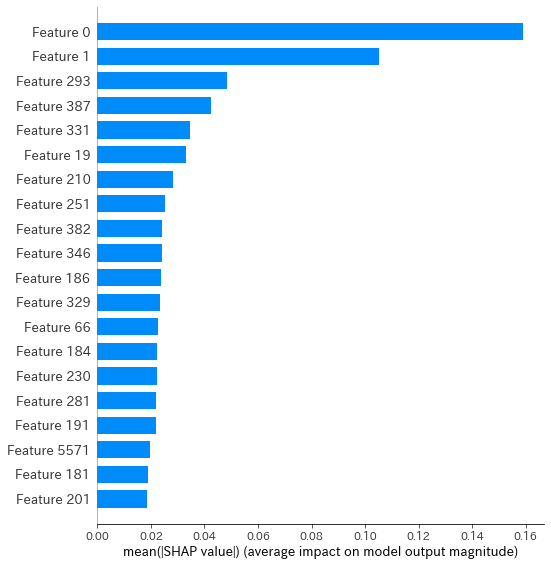

In [131]:
shap.initjs()
shap.summary_plot(shap_values, X_trainp, plot_type="bar",show=False)

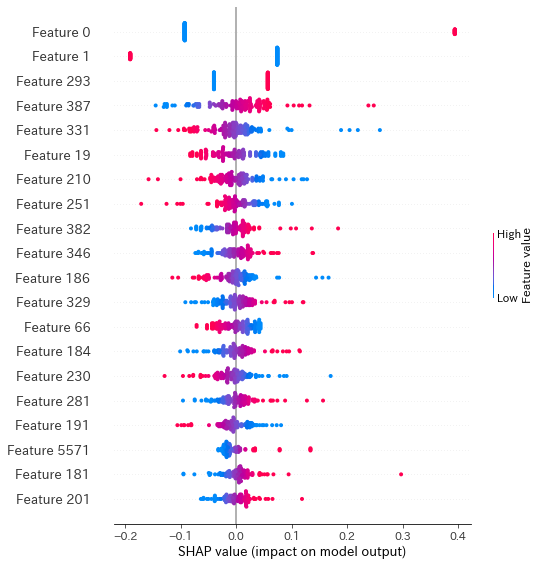

In [132]:
shap.summary_plot(shap_values, X_trainp)

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, features=X_train, max_display=10)